In [5]:
import os
import json

import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy_indexed as npi
from scipy.io import loadmat

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])
from utils.ipm import NeuronLoader

from imblearn.under_sampling import RandomUnderSampler as rus
from scipy.ndimage import gaussian_filter1d as smooth

from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts
# from sklearn.metrics import recall_score

In [6]:
fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

In [9]:
import pickle
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
info.head()

,img,sfr,con,sup,mid,fac,bod,art,nat,cat
0,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face
1,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face part,none,none,False,False,False,False,none
2,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face
3,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,misc,none,none,False,False,False,False,none
4,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face


# Ordinal

## Model Fitting

In [ ]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    
    inds, X, y, l = [], [], [], []
    for i, g in enumerate(np.unique(groups)):
        if 'none'==g:
            continue

        inds.append(np.random.choice(np.argwhere(groups==g).squeeze(), size=n, replace=False))
        X.extend(data[inds[-1]])
        y.extend(i * np.ones_like(inds[-1]))
        l.append(g)
    
    X, y = np.array(X), np.array(y)
    rind = np.random.permutation(X.shape[0])
    X, y = X[rind], y[rind]
    return X, y, l

In [ ]:
def initmetric(nmb_bin, nmb_rep):
    cfn = np.nan * np.ones([2, 2, nmb_bin, nmb_rep])
    dth = np.nan * np.ones([nmb_bin, nmb_rep])
    dpr = np.nan * np.ones([nmb_bin, nmb_rep])
    auc = np.nan * np.ones([nmb_bin, nmb_rep])
    return cfn, dth, dpr, auc

In [ ]:
def calcmetric(mdl, X_test, y_test):
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)
    dist = mdl['svc'].decision_function(X_test) / np.linalg.norm(mdl['svc'].coef_)
    d0, d1 = dist[y_test==0], dist[y_test==1]
    
    cfn = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)
    dth = np.abs(d0.mean() - d1.mean())
    dpr = np.sqrt(2) * np.abs(d0.mean() - d1.mean()) / np.sqrt(d0.var() + d1.var())
    auc = roc_auc_score(y_test, y_prob[:, 1])
    
    return cfn, dth, dpr, auc

In [ ]:
def savemetric(path: str, prefix: str, cfn: np.array, dth: np.array, dpr: np.array, auc: np.array) -> None:
    np.save(os.path.join(path, prefix + '-cfn.npy'), cfn)
    np.save(os.path.join(path, prefix + '-dth.npy'), dth)
    np.save(os.path.join(path, prefix + '-dpr.npy'), dpr)
    np.save(os.path.join(path, prefix + '-auc.npy'), auc)

In [ ]:
nmb_component = .95
nmb_rep = 200

for monkey in ["both"]:
    for selectivity in ["fast", "slow"]:
        data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')
        time_bins = np.arange(data.it.shape[2], step=5)
        
        out_path  = f'G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-{selectivity.lower()}'
        os.makedirs(out_path, exist_ok=True)
        
        for region in ['it', 'pfc']:
            region_data = data.it if region=='it' else data.pfc
            
            for ordination in ['sup', 'mid']:
                nmb_smp = info[ordination].groupby(info[ordination]).count().drop('none').values.min()
                nmb_cls = info[ordination].groupby(info[ordination]).count().drop('none').size
                nmb_bin = time_bins.size
            
                cfn, dth, dpr, auc = initmetric(nmb_bin, nmb_rep)

                for seed in (pbar := tqdm(range(nmb_rep))):
                    pbar.set_description(monkey+"-"+selectivity+"-"+region+"-"+ordination)
                    X, y, l = mkeqdata(region_data, info[ordination].to_numpy(), nmb_smp, seed=seed)

                    for biter, ibin in enumerate(time_bins):
                        Xr = X[:,:,ibin]
                        X_train, X_test, y_train, y_test = tts(Xr, y, test_size=.3,
                                                               random_state=seed, shuffle=True, stratify=y)
                        mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
                                                                  random_state=seed)).fit(X_train, y_train)

                        # cfn[:,:,biter,seed] = confusion_matrix(y_test, mdl.predict(X_test), labels=np.arange(nmb_cls), sample_weight=None, normalize=None)
                        cfn[:,:,biter,seed], dth[biter,seed], dpr[biter,seed], auc[biter,seed] = calcmetric(mdl, X_test, y_test)

                prefix = f"{region}"
                savemetric(out_path, prefix + "-" + ordination, cfn, dth, dpr, auc)
                with open(os.path.join(out_path, prefix + '-meta.npy'), "wb") as handler:
                    pickle.dump({'labels': l, 'time': data.time[time_bins]}, handler)

## Visualization

### Time Series

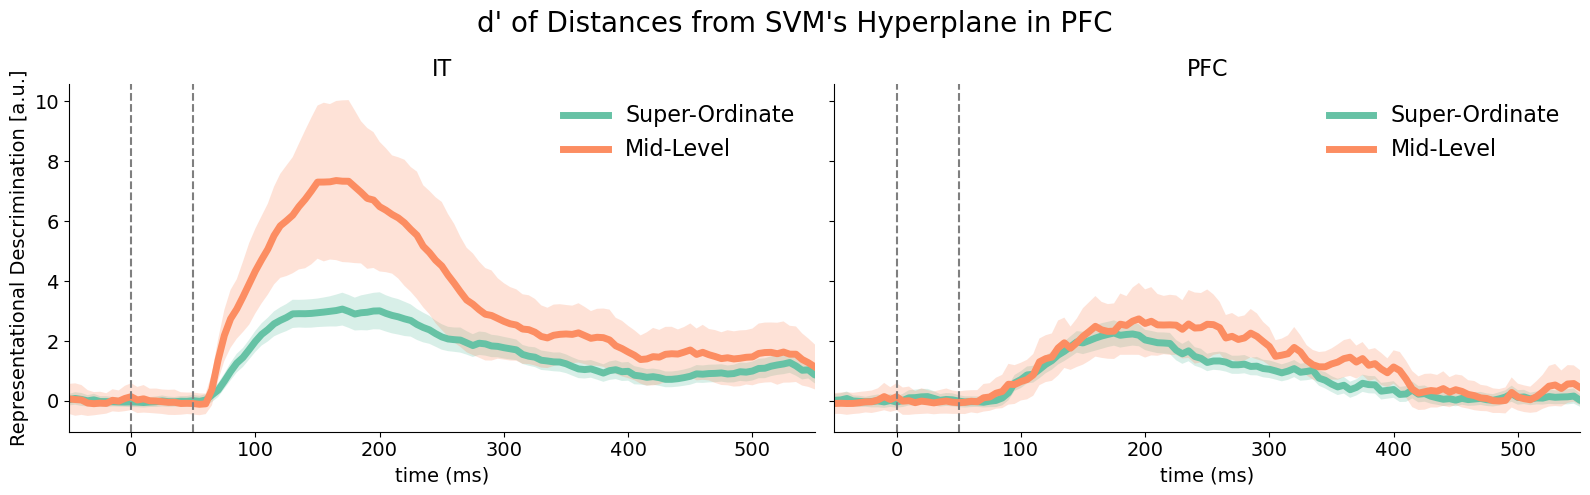

In [12]:
fontsize = 16
titlefontsize = 36
make_smooth = False
sns.set_palette("Set2")

for monkey in ['both']:
    for selectivity in ['fast']:
        for statistic in ['dpr']:
            out_path = f"G:/Results/SUA/svm/{monkey.lower()}-{selectivity.lower()}"
            data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

            fig, axs = plt.subplots(1, 2, figsize=np.array([16, 5]), dpi=100, sharey=True)
            sns.despine()

            for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
                ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-{statistic}.npy'))
                so = np.load(os.path.join(out_path, f'{region.lower()}-sup-{statistic}.npy'))
                with open(f"{out_path}\\it-meta.npy", "rb") as handler:
                    meta = pickle.load(handler) 

                for metric, va in zip([so, ml], ["top", "bottom"]):
                    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
                    anot = metric.mean(1).max()
                    # metric /= np.array([so.mean(1), ml.mean(1)]).max()
                    metric -= metric[(meta['time'] > -50) & (meta['time'] <= 0), :].mean()
                    ax.plot(meta['time'], metric.mean(1), lw=5)
                    ax.fill_between(meta['time'], metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
                    ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
                                xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
                                xycoords='data', fontsize=18, 
                                horizontalalignment='center',
                                verticalalignment=va)
                ax.set_title(region.upper(), fontsize=16)    
                ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=16)
                ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
                ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
                ax.set_xlim(-50, 550)
                ax.set_xlabel('time (ms)', fontsize=14)
                ax.tick_params(axis='both', which='major', labelsize=14)

            if statistic == 'dth':
                fig.suptitle(f'Absolute Difference of Mean Distances from SVM\'s Hyperplane in {region.upper()}', fontsize=20)
                axs[0].set_ylabel(r'$\sqrt{2} \times |\mu_1-\mu_2|}$', fontsize=14)
            elif statistic == 'dpr':
                fig.suptitle(f"d' of Distances from SVM\'s Hyperplane in {region.upper()}", fontsize=20)
                # axs[0].set_ylabel(r'$\frac{\sqrt{2} \times |\mu_1-\mu_2|}{\sqrt{\sigma_1^2+\sigma_2^2}} $', fontsize=14)
                axs[0].set_ylabel(r'Representational Descrimination [a.u.]', fontsize=14)
            elif statistic == 'auc':
                fig.suptitle(f'Area under Receptive-Operating Curve in {region.upper()}', fontsize=20)
                axs[0].set_ylabel(r'$S_{ROC}$', fontsize=14)

            fig.tight_layout()
            # fig.savefig(os.path.join(out_path, f"{statistic}.eps"), format='eps')
            # fig.savefig(os.path.join(out_path, f"{statistic}.jpg"), dpi=1200)

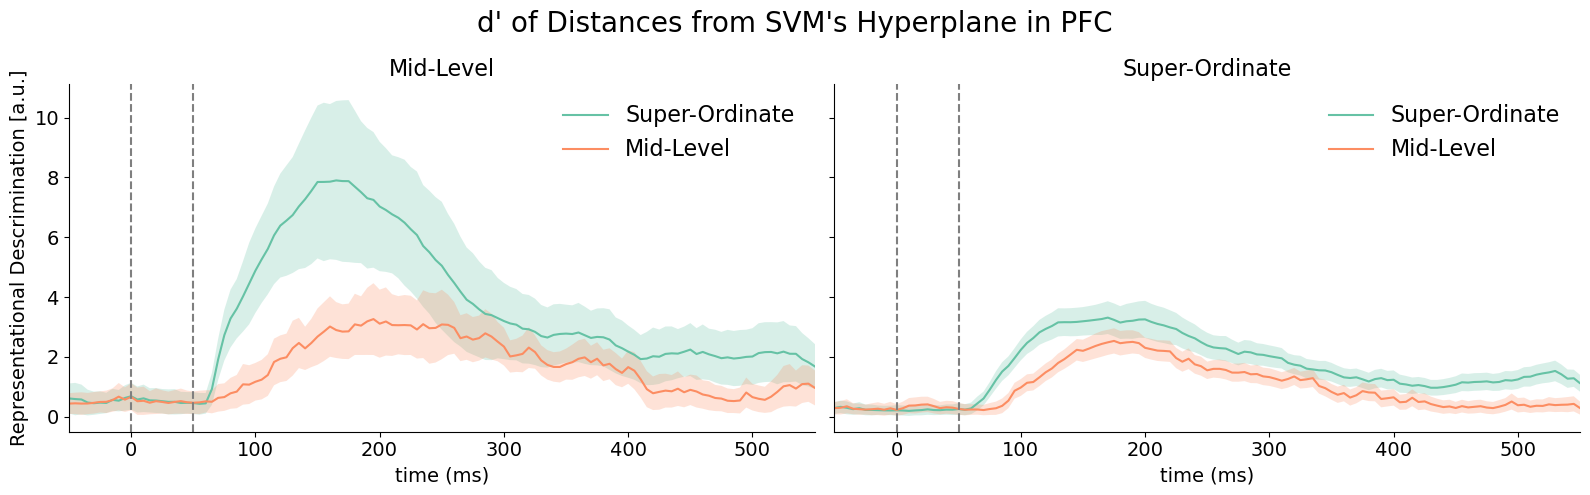

In [151]:
fontsize = 16
titlefontsize = 36
make_smooth = False
sns.set_palette("Set2")

for monkey in ['both']:
    for selectivity in ['fast']:
        for statistic in ['dpr']:
            out_path = f"G:/Results/SUA/svm/{monkey.lower()}-{selectivity.lower()}"
            data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

            fig, axs = plt.subplots(1, 2, figsize=np.array([16, 5]), dpi=100, sharey=True)
            sns.despine()

            mli = np.load(os.path.join(out_path, f'it-mid-{statistic}.npy'))
            mlp = np.load(os.path.join(out_path, f'pfc-mid-{statistic}.npy'))
            soi = np.load(os.path.join(out_path, f'it-sup-{statistic}.npy'))
            sop = np.load(os.path.join(out_path, f'pfc-sup-{statistic}.npy'))

            for m in [mli, mlp]:
                axs[0].plot(tim, m.mean(1))
                axs[0].fill_between(tim, m.mean(1) + m.std(1), m.mean(1) - m.std(1), label='_nolegend_', alpha=.25)
            
            for m in [soi, sop]:
                axs[1].plot(tim, m.mean(1))
                axs[1].fill_between(tim, m.mean(1) + m.std(1), m.mean(1) - m.std(1), label='_nolegend_', alpha=.25)

            axs[0].set_title("Mid-Level", fontsize=16)
            axs[1].set_title("Super-Ordinate", fontsize=16)

            for ax in axs.flatten():
                ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=16)
                ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
                ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
                ax.set_xlim(-50, 550)
                ax.set_xlabel('time (ms)', fontsize=14)
                ax.tick_params(axis='both', which='major', labelsize=14)

            # for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
            #     ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-{statistic}.npy'))
            #     so = np.load(os.path.join(out_path, f'{region.lower()}-sup-{statistic}.npy'))
            #     with open(f"{out_path}\\it-meta.npy", "rb") as handler:
            #         meta = pickle.load(handler) 

            #     for metric, va in zip([so, ml], ["top", "bottom"]):
            #         metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
            #         anot = metric.mean(1).max()
            #         # metric /= np.array([so.mean(1), ml.mean(1)]).max()
            #         metric -= metric[(meta['time'] > -50) & (meta['time'] <= 0), :].mean()
            #         ax.plot(meta['time'], metric.mean(1), lw=5)
            #         ax.fill_between(meta['time'], metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
            #         ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
            #                     xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
            #                     xycoords='data', fontsize=18, 
            #                     horizontalalignment='center',
            #                     verticalalignment=va)
            #     ax.set_title(region.upper(), fontsize=16)    
            #     ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=16)
            #     ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
            #     ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
            #     ax.set_xlim(-50, 550)
            #     ax.set_xlabel('time (ms)', fontsize=14)
            #     ax.tick_params(axis='both', which='major', labelsize=14)

            if statistic == 'dth':
                fig.suptitle(f'Absolute Difference of Mean Distances from SVM\'s Hyperplane in {region.upper()}', fontsize=20)
                axs[0].set_ylabel(r'$\sqrt{2} \times |\mu_1-\mu_2|}$', fontsize=14)
            elif statistic == 'dpr':
                fig.suptitle(f"d' of Distances from SVM\'s Hyperplane in {region.upper()}", fontsize=20)
                # axs[0].set_ylabel(r'$\frac{\sqrt{2} \times |\mu_1-\mu_2|}{\sqrt{\sigma_1^2+\sigma_2^2}} $', fontsize=14)
                axs[0].set_ylabel(r'Representational Descrimination [a.u.]', fontsize=14)
            elif statistic == 'auc':
                fig.suptitle(f'Area under Receptive-Operating Curve in {region.upper()}', fontsize=20)
                axs[0].set_ylabel(r'$S_{ROC}$', fontsize=14)

            fig.tight_layout()
            # fig.savefig(os.path.join(out_path, f"{statistic}.eps"), format='eps')
            # fig.savefig(os.path.join(out_path, f"{statistic}.jpg"), dpi=1200)

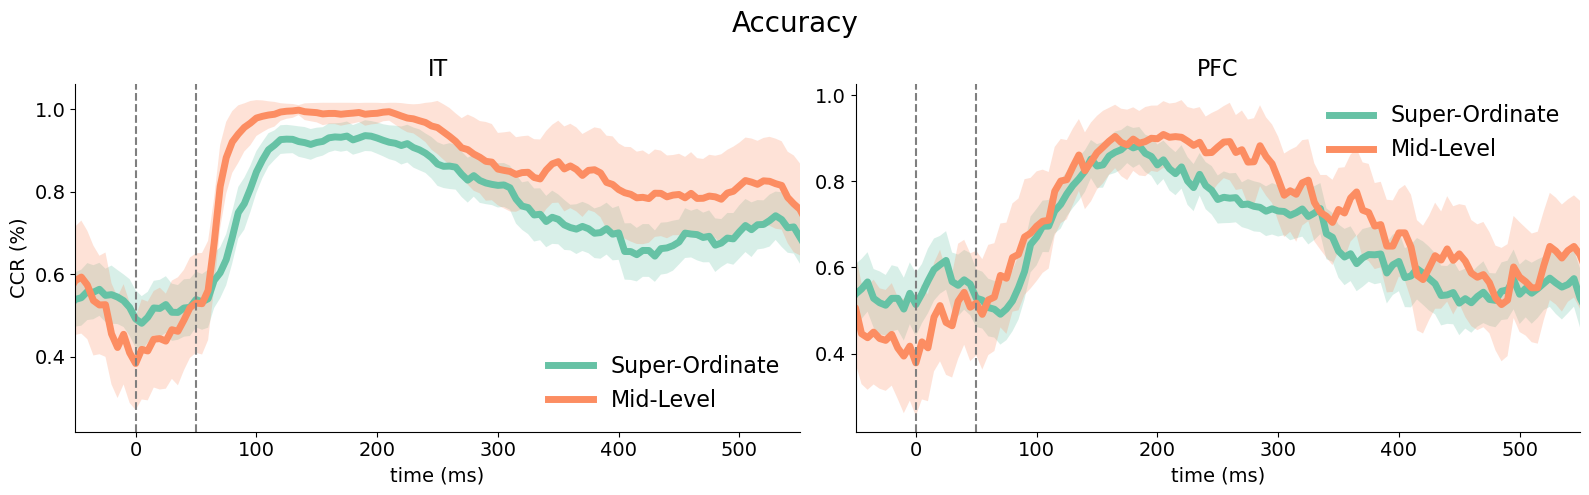

In [14]:
for monkey in ['both']:
    for selectivity in ['fast']:
        out_path = f"G:/Results/SUA/svm/{monkey.lower()}-{selectivity.lower()}"
        data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

        fig, axs = plt.subplots(1, 2, figsize=np.array([16, 5]), dpi=100)
        sns.despine()

        for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
            ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-cfn.npy'))
            so = np.load(os.path.join(out_path, f'{region.lower()}-sup-cfn.npy'))
            with open(f"{out_path}\\it-meta.npy", "rb") as handler:
                meta = pickle.load(handler) 
            so = np.diagonal(so, axis1=0, axis2=1).sum(-1) / so.sum((0, 1))
            ml = np.diagonal(ml, axis1=0, axis2=1).sum(-1) / ml.sum((0, 1))

            for metric, va in zip([so, ml], ["top", "bottom"]):
                metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
                anot = metric.mean(1).max()
                # metric /= np.array([so.mean(1), ml.mean(1)]).max()
                # metric -= metric[(meta['time'] > -50) & (meta['time'] <= 0), :].mean()
                ax.plot(meta['time'], metric.mean(1), lw=5)
                ax.fill_between(meta['time'], metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
                ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
                            xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
                            xycoords='data', fontsize=18, 
                            horizontalalignment='center',
                            verticalalignment=va)
            ax.set_title(region.upper(), fontsize=16)    
            ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=16)
            ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
            ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
            ax.set_xlim(-50, 550)
            ax.set_xlabel('time (ms)', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=14)
        
        fig.suptitle(f'Accuracy', fontsize=20)
        axs[0].set_ylabel(r'CCR (%)', fontsize=14)

        fig.tight_layout()
        # fig.savefig(os.path.join(out_path, f"{statistic}.eps"), format='eps')
        # fig.savefig(os.path.join(out_path, "acc.png"), dpi=1200)

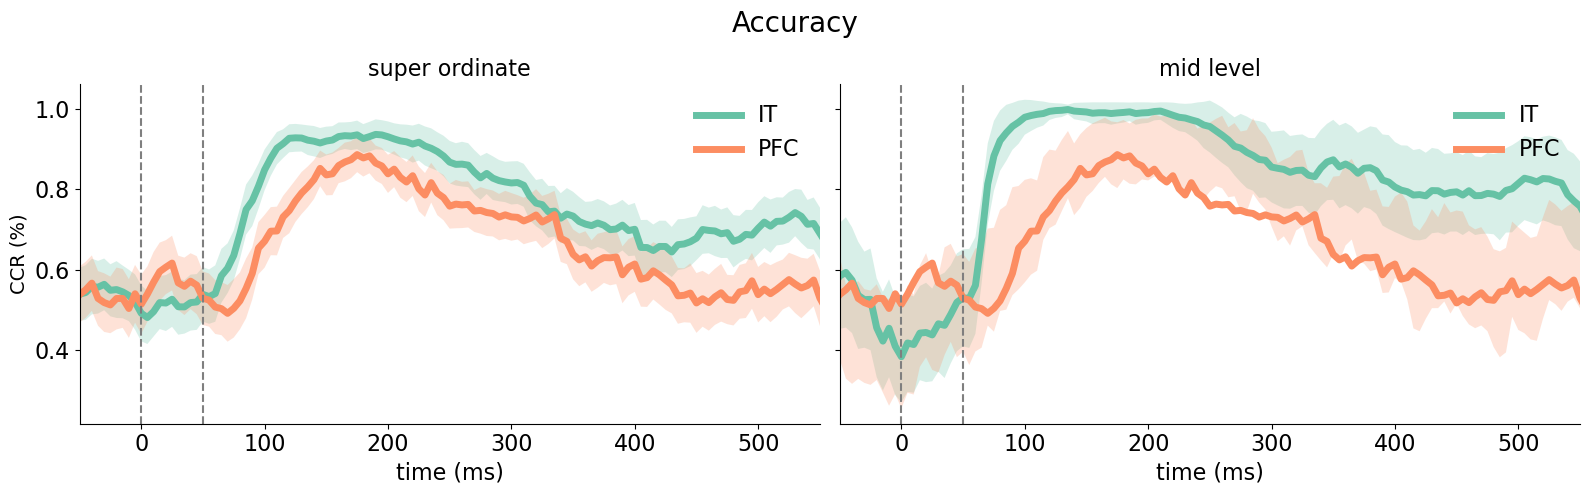

In [16]:
out_path = "G:/Results/SUA/svm/both-fast"
# data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

fig, axs = plt.subplots(1, 2, figsize=np.array([16, 5]), dpi=100, sharey=True)
sns.despine()

# for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
ml = np.load(os.path.join(out_path, 'it-mid-cfn.npy'))
ml = np.diagonal(ml, axis1=0, axis2=1).sum(-1) / ml.sum((0, 1))
mli = ml if not make_smooth else np.transpose(smooth(np.transpose(ml), sigma=3))
so = np.load(os.path.join(out_path, 'it-sup-cfn.npy'))
so = np.diagonal(so, axis1=0, axis2=1).sum(-1) / so.sum((0, 1))
soi = so if not make_smooth else np.transpose(smooth(np.transpose(so), sigma=3))

ml = np.load(os.path.join(out_path, 'pfc-mid-cfn.npy'))
ml = np.diagonal(ml, axis1=0, axis2=1).sum(-1) / ml.sum((0, 1))
mlp = ml if not make_smooth else np.transpose(smooth(np.transpose(ml), sigma=3))
so = np.load(os.path.join(out_path, 'pfc-sup-cfn.npy'))
so = np.diagonal(so, axis1=0, axis2=1).sum(-1) / so.sum((0, 1))
sop = so if not make_smooth else np.transpose(smooth(np.transpose(so), sigma=3))
with open(f"{out_path}\\pfc-meta.npy", "rb") as handler:
    meta = pickle.load(handler) 

del so, ml

axs[0].plot(meta['time'], soi.mean(1), lw=5)
axs[0].fill_between(meta['time'], soi.mean(1) + soi.std(1), soi.mean(1) - soi.std(1), label='_nolegend_', alpha=.25)

axs[0].plot(meta['time'], sop.mean(1), lw=5)
axs[0].fill_between(meta['time'], sop.mean(1) + sop.std(1), sop.mean(1) - sop.std(1), label='_nolegend_', alpha=.25)

axs[1].plot(meta['time'], mli.mean(1), lw=5)
axs[1].fill_between(meta['time'], mli.mean(1) + mli.std(1), mli.mean(1) - mli.std(1), label='_nolegend_', alpha=.25)

axs[1].plot(meta['time'], sop.mean(1), lw=5)
axs[1].fill_between(meta['time'], mlp.mean(1) + mlp.std(1), mlp.mean(1) - mlp.std(1), label='_nolegend_', alpha=.25)

axs[0].set_title("super ordinate", fontsize=16)
axs[1].set_title("mid level", fontsize=16)

for ax in axs:
    ax.legend(["IT", "PFC"], frameon=False, fontsize=fontsize)
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
    ax.set_xlim(-50, 550)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

fig.suptitle(f'Accuracy', fontsize=20)
axs[0].set_ylabel(r'CCR (%)', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(out_path, "acc2.jpg"))

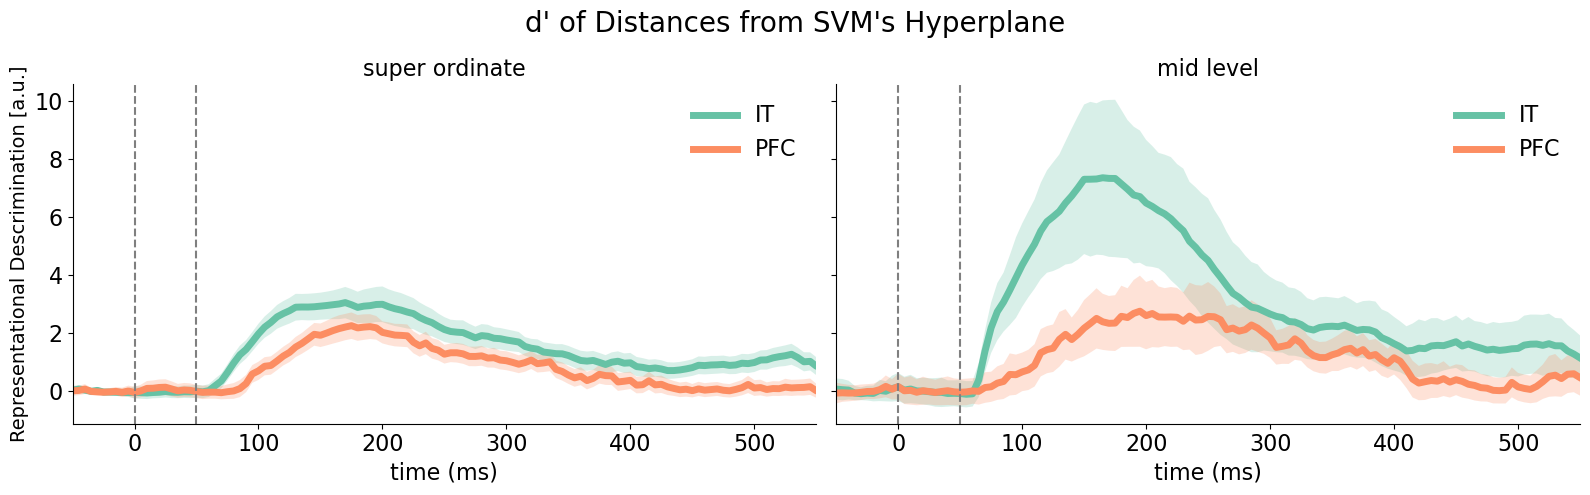

In [17]:
out_path = "G:/Results/SUA/svm/both-fast"
# data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

fig, axs = plt.subplots(1, 2, figsize=np.array([16, 5]), dpi=100, sharey=True)
sns.despine()

# for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
ml = np.load(os.path.join(out_path, 'it-mid-dpr.npy'))
mli = ml if not make_smooth else np.transpose(smooth(np.transpose(ml), sigma=3))
so = np.load(os.path.join(out_path, 'it-sup-dpr.npy'))
soi = so if not make_smooth else np.transpose(smooth(np.transpose(so), sigma=3))

ml = np.load(os.path.join(out_path, 'pfc-mid-dpr.npy'))
mlp = ml if not make_smooth else np.transpose(smooth(np.transpose(ml), sigma=3))
so = np.load(os.path.join(out_path, 'pfc-sup-dpr.npy'))
sop = so if not make_smooth else np.transpose(smooth(np.transpose(so), sigma=3))
with open(f"{out_path}\\pfc-meta.npy", "rb") as handler:
    meta = pickle.load(handler) 

del so, ml

for x in [soi, sop, mli, mlp]:
    x -= x[(meta['time'] < 0) & (meta['time'] >= -50), :].mean(0)
    # x /= x.mean(1).max()

axs[0].plot(meta['time'], soi.mean(1), lw=5)
axs[0].fill_between(meta['time'], soi.mean(1) + soi.std(1), soi.mean(1) - soi.std(1), label='_nolegend_', alpha=.25)

axs[0].plot(meta['time'], sop.mean(1), lw=5)
axs[0].fill_between(meta['time'], sop.mean(1) + sop.std(1), sop.mean(1) - sop.std(1), label='_nolegend_', alpha=.25)

axs[1].plot(meta['time'], mli.mean(1), lw=5)
axs[1].fill_between(meta['time'], mli.mean(1) + mli.std(1), mli.mean(1) - mli.std(1), label='_nolegend_', alpha=.25)

axs[1].plot(meta['time'], mlp.mean(1), lw=5)
axs[1].fill_between(meta['time'], mlp.mean(1) + mlp.std(1), mlp.mean(1) - mlp.std(1), label='_nolegend_', alpha=.25)

axs[0].set_title("super ordinate", fontsize=16)
axs[1].set_title("mid level", fontsize=16)

for ax in axs:
    ax.legend(["IT", "PFC"], frameon=False, fontsize=fontsize)
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
    ax.set_xlim(-50, 550)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

fig.suptitle(f"d' of Distances from SVM\'s Hyperplane", fontsize=20)
axs[0].set_ylabel(r'Representational Descrimination [a.u.]', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(out_path, "dpr2.jpg"))

### Onsets, Based on Statistical Testing with Baseline

In [89]:
mli = np.load(os.path.join(out_path, f'it-mid-dpr.npy'))
soi = np.load(os.path.join(out_path, f'it-sup-dpr.npy'))
mlp = np.load(os.path.join(out_path, f'pfc-mid-dpr.npy'))
sop = np.load(os.path.join(out_path, f'pfc-sup-dpr.npy'))
tim = meta['time']

MLI = 0
SOI = 1
MLP = 2
SOP = 3

nsw = 10

onsets = []
for m in [mli, soi, mlp, sop]:
    bl = (tim < 0)
    ons = []
    for rep in range(m.shape[1]):
        rm = m[:, np.random.choice(m.shape[1], m.shape[1], replace=True)].mean(1)
        # rm = m[:,]
        pv = []
        for itim in range(len(tim)):
            pv.append(1-((rm[itim] - rm[bl].flatten()) > 0).mean())
        pv = np.array(pv)
        pv[bl] = 1
        cp = np.convolve(pv < 0.05, np.ones(nsw), mode='same')
        wis = np.argwhere(cp == nsw)
        if wis.size == 0:
            ons.extend([np.nan])
        else:
            ons.extend(tim[wis[0]])
            if ons[-1] < 0:
                raise(Exception)
    onsets.append(ons)
onsets = np.array(onsets)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

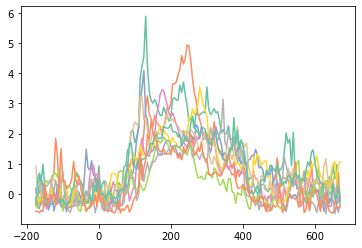

In [88]:
plt.plot(tim, mlp[:, 10:20] - mlp[bl, 10:20].mean(0));

In [85]:
mlp.shape

(170, 200)

In [122]:
onsets = []
for m in [mli, soi, mlp, sop]:
    bl = (tim < 0) & (tim > -100)
    ons = []

    for iRep in range(m.shape[1]):
        rm = m[:, iRep] - m[bl, iRep].mean()
        # rm -= rm[bl,]
        # isOverThreshold = rm > 2.5
        thr = 3 * rm[tim < 0].std()
        cp = np.convolve(rm > thr, np.ones(10), mode='same')
        
        try:
            o = np.argwhere(cp==10)[0] - 10
            ons.append(o)
        except Exception:
            pass
        
        # if tim[o] < 10:
        #     plt.plot(tim, rm)
        #     plt.plot(tim[rm > 2.5], rm[rm > 2.5])
        #     plt.plot(tim, cp)
        #     plt.axvline(tim[o])
            # break
        # ons.append()
    
        # break
    onsets.append(np.array(ons))
    # break
        # rm = m[:, np.random.choice(m.shape[1], m.shape[1], replace=True)].mean(1)
    #     rm = m[:, rep]
    #     pv = []
    #     for itim in range(len(tim)):
    #         pv.append(1-((rm[itim] - rm[bl].flatten()) > 0).mean())
    #     pv = np.array(pv)
    #     pv[bl] = 1
    #     cp = np.convolve(pv < 0.05, np.ones(nsw), mode='same')
    #     wis = np.argwhere(cp == nsw)
    #     if wis.size == 0:
    #         ons.extend([np.nan])
    #     else:
    #         ons.extend(tim[wis[0]])
    #         if ons[-1] < 0:
    #             raise(Exception)
    # onsets.append(ons)
# onsets = np.array(onsets)

<AxesSubplot:>

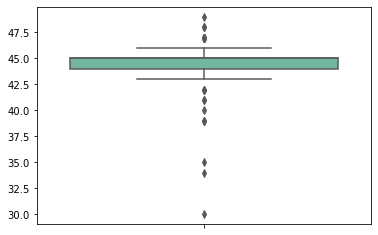

In [137]:
# sns.boxplot(y=onsets[0])
sns.boxplot(y=onsets[1])
# sns.histplot(onsets[1], bins=np.arange(30, 60, 5))


<AxesSubplot:ylabel='Count'>

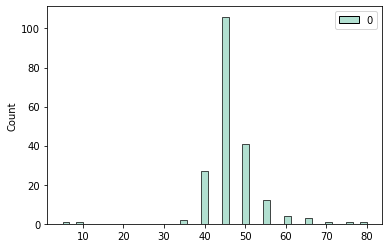

In [114]:
sns.histplot(tim[np.array(ons)])

In [106]:
sns.histplot(ons)

<AxesSubplot:ylabel='Count'>

Error in callback <function flush_figures at 0x000001812B5A95E0> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:>

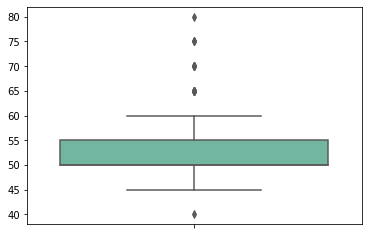

In [74]:
sns.boxplot(y=tim[np.array(onsets).flatten()])

#### `regplot`

In [41]:
def myscatter(ax, x, y):
    axrange = [np.nanmin(np.c_[x, y]) * 0.9, np.nanmax(np.c_[x, y]) * 1.1]

    sns.regplot(x=x, y=y, ax=ax, x_jitter=2, y_jitter=2, fit_reg=False)
    ax.plot(axrange, axrange, 'k--', alpha=0.3)
    sns.despine()
    ax.axis('equal')
    ax.axis('square')

p-value: 0.07


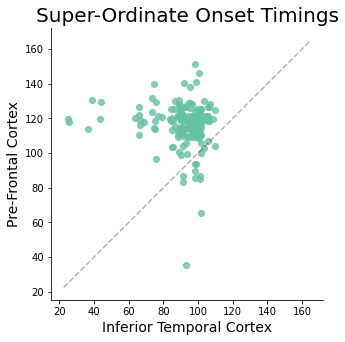

In [42]:
x = onsets[1, :]
y = onsets[3, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Inferior Temporal Cortex', fontsize=14)
plt.ylabel('Pre-Frontal Cortex', fontsize=14)
plt.title('Super-Ordinate Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y) < 0).mean():.2f}")

p-value: 0.00


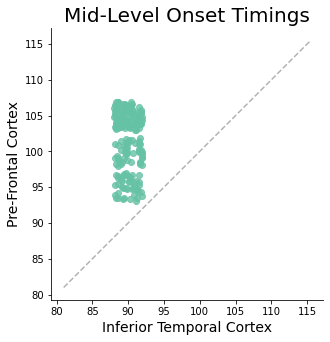

In [23]:
x = onsets[0, :]
y = onsets[2, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Inferior Temporal Cortex', fontsize=14)
plt.ylabel('Pre-Frontal Cortex', fontsize=14)
plt.title('Mid-Level Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y) < 0).mean():.2f}")

p-value: 1.00


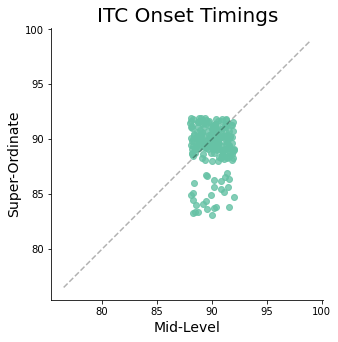

In [24]:
x = onsets[0, :]
y = onsets[1, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Mid-Level', fontsize=14)
plt.ylabel('Super-Ordinate', fontsize=14)
plt.title('ITC Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y) < 0).mean():.2f}")

p-value: 0.00


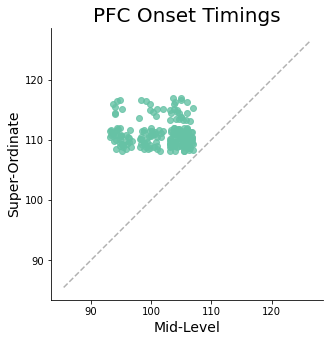

In [25]:
x = onsets[2, :]
y = onsets[3, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Mid-Level', fontsize=14)
plt.ylabel('Super-Ordinate', fontsize=14)
plt.title('PFC Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y) < 0).mean():.2f}")

#### `jointplot` 

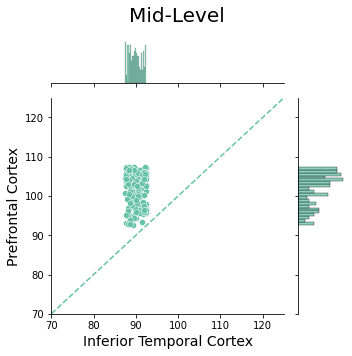

In [26]:
x = onsets[MLI, :]
y = onsets[MLP, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[70, 125], 
                   ylim=[70, 125], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Inferior Temporal Cortex', fontsize=14)
ax.ax_joint.set_ylabel('Prefrontal Cortex', fontsize=14)

ax.fig.suptitle('Mid-Level', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "mid-onset-latency-ttest.jpg"),
            dpi=1200)
# plt.close()

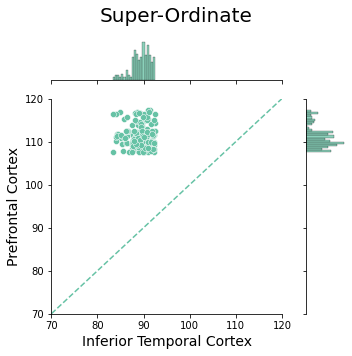

In [27]:
x = onsets[SOI, :]
y = onsets[SOP, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[70, 120], 
                   ylim=[70, 120], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Inferior Temporal Cortex', fontsize=14)
ax.ax_joint.set_ylabel('Prefrontal Cortex', fontsize=14)

ax.fig.suptitle('Super-Ordinate', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "sup-onset-latency-ttest.jpg"),
            dpi=1200)
# plt.close()

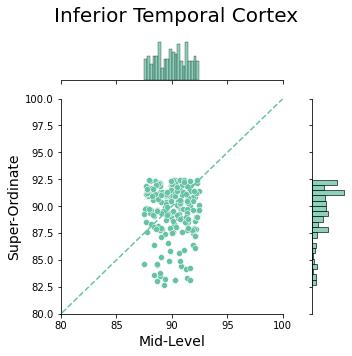

In [28]:
x = onsets[MLI, :]
y = onsets[SOI, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[80, 100], 
                   ylim=[80, 100], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Mid-Level', fontsize=14)
ax.ax_joint.set_ylabel('Super-Ordinate', fontsize=14)

ax.fig.suptitle('Inferior Temporal Cortex', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "itc-onset-latency-ttest.jpg"),
            dpi=1200)
# plt.close()

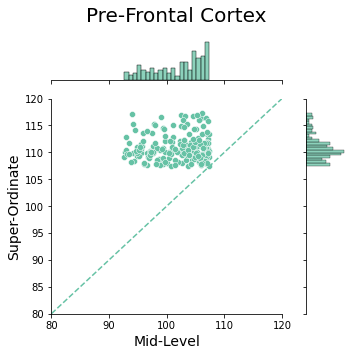

In [29]:
x = onsets[MLP, :]
y = onsets[SOP, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[80, 120], 
                   ylim=[80, 120], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Mid-Level', fontsize=14)
ax.ax_joint.set_ylabel('Super-Ordinate', fontsize=14)

ax.fig.suptitle('Pre-Frontal Cortex', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "pfc-onset-latency-ttest.jpg"),
            dpi=1200)
# plt.close()

### Based on Thresholding Peak Value

In [721]:
mli = np.load(os.path.join(out_path, f'it-mid-dpr.npy'))
soi = np.load(os.path.join(out_path, f'it-sup-dpr.npy'))
mlp = np.load(os.path.join(out_path, f'pfc-mid-dpr.npy'))
sop = np.load(os.path.join(out_path, f'pfc-sup-dpr.npy'))
tim = meta['time']

MLI = 0
SOI = 1
MLP = 2
SOP = 3

nsw = 5

onsets = []
for m in [mli, soi, mlp, sop]:
    m = np.transpose(smooth(np.transpose(m), sigma=1))
    bl = (tim < 0) & (tim >= -100)
    ons = []
    for rep in range(m.shape[1]):
        rm = m[:, np.random.choice(m.shape[1], m.shape[1], replace=True)].mean(1)
        # rm = m[:, rep]
        rm -= rm[bl].mean()
        # plt.plot(tim, rm)
        maxv = rm[(tim > 50) & (tim < 200)].max()
        thresh = 0.2 * (maxv)
        ht = rm > thresh
        cht = np.convolve(ht, np.ones(nsw), 'same') == nsw
        cht[tim < 70] = 0
        ons.extend(tim[np.argwhere(cht)[0] - nsw])
        # if(tim[np.argwhere(cht)[0] - nsw] < 55):
        #     plt.plot(tim, rm)
        #     plt.plot(tim, cht)
        #     ons[-1]
        #     raise(Exception)
    onsets.append(ons)
onsets = np.array(onsets)

#### `regplot`

In [441]:
def myscatter(ax, x, y):
    axrange = [np.nanmin(np.c_[x, y]) * 0.9, np.nanmax(np.c_[x, y]) * 1.1]

    sns.regplot(x=x, y=y, ax=ax, x_jitter=2, y_jitter=2, fit_reg=False)
    ax.plot(axrange, axrange, 'k--', alpha=0.3)
    sns.despine()
    ax.axis('equal')
    ax.axis('square')

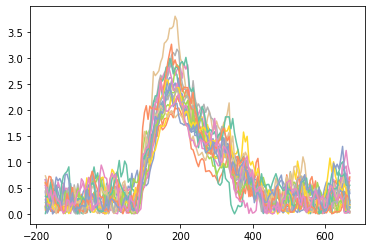

In [670]:
plt.plot(tim, sop[:, :20]);

p-value: 0.032


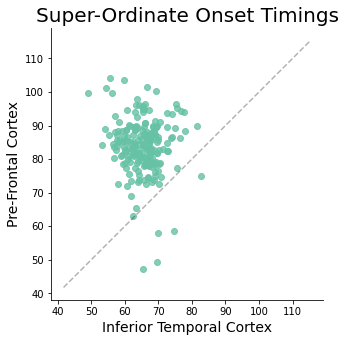

In [443]:
x = onsets[SOI, :]
y = onsets[SOP, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Inferior Temporal Cortex', fontsize=14)
plt.ylabel('Pre-Frontal Cortex', fontsize=14)
plt.title('Super-Ordinate Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y.reshape(-1, 1)) < 0).mean():.3f}")

In [623]:
x = onsets[SOI, :]
y = onsets[SOP, :]

# x += 0 * np.random.random(x.shape)
# y += 0 * np.random.random(y.shape)
fig = plt.figure()
ax = sns.jointplot(x=x+4*np.random.random(x.shape), 
                   y=y+4*np.random.random(x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[40, 100], 
                   ylim=[40, 100], 
                   ratio=4, marginal_kws=dict(bins=30))
ax.ax_joint.plot([30, 100], [30, 100], '--')
# ax.plot_marginals(sns.rugplot, color='pink', height=-.2, clip_on=False);

fig.tight_layout()
plt.savefig(os.path.join(out_path, "itc-onset-latency-thresh.jpg"), dpi=1200)
plt.close();

<Figure size 432x288 with 0 Axes>

In [424]:
((x-y.reshape(1, -1)) < 0).shape

(1, 200)

p-value: 0.194


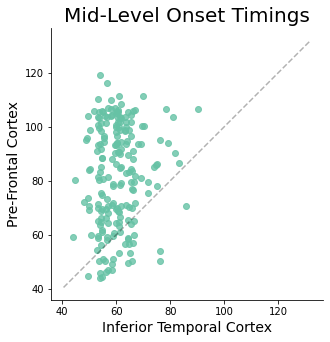

In [428]:
x = onsets[MLI, :]
y = onsets[MLP, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Inferior Temporal Cortex', fontsize=14)
plt.ylabel('Pre-Frontal Cortex', fontsize=14)
plt.title('Mid-Level Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y.reshape(-1, 1)) < 0).mean():.3f}")

p-value: 0.519


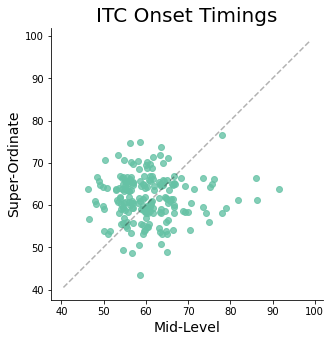

In [427]:
x = onsets[MLI, :]
y = onsets[SOI, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Mid-Level', fontsize=14)
plt.ylabel('Super-Ordinate', fontsize=14)
plt.title('ITC Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y.reshape(-1, 1)) < 0).mean():.3f}")

p-value: 0.575


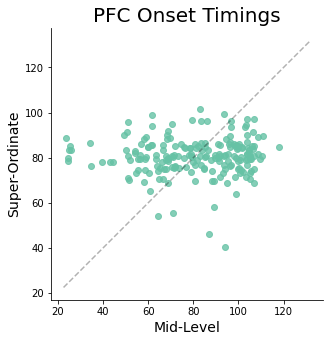

In [405]:
x = onsets[MLP, :]
y = onsets[SOP, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
myscatter(ax, x, y)
plt.xlabel('Mid-Level', fontsize=14)
plt.ylabel('Super-Ordinate', fontsize=14)
plt.title('PFC Onset Timings', fontsize=20);
print(f"p-value: {1 - ((x-y.reshape(-1, 1)) < 0).mean():.3f}")

#### `jointplot` 

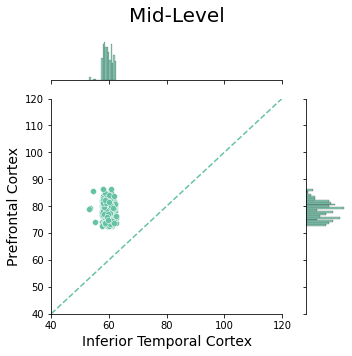

In [723]:
x = onsets[MLI, :]
y = onsets[MLP, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[40, 120], 
                   ylim=[40, 120], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Inferior Temporal Cortex', fontsize=14)
ax.ax_joint.set_ylabel('Prefrontal Cortex', fontsize=14)

ax.fig.suptitle('Mid-Level', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "mid-onset-latency-thresh.jpg"),
            dpi=1200)
# plt.close()

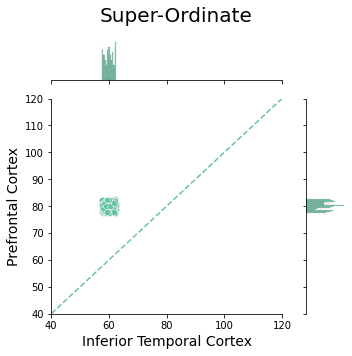

In [725]:
x = onsets[SOI, :]
y = onsets[SOP, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[40, 120], 
                   ylim=[40, 120], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Inferior Temporal Cortex', fontsize=14)
ax.ax_joint.set_ylabel('Prefrontal Cortex', fontsize=14)

ax.fig.suptitle('Super-Ordinate', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "sup-onset-latency-thresh.jpg"),
            dpi=1200)
# plt.close()

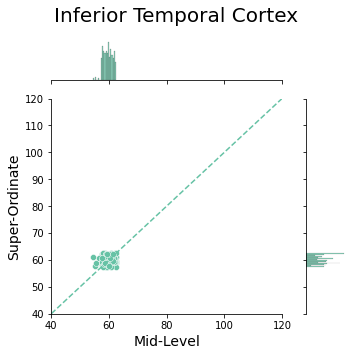

In [726]:
x = onsets[MLI, :]
y = onsets[SOI, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[40, 120], 
                   ylim=[40, 120], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Mid-Level', fontsize=14)
ax.ax_joint.set_ylabel('Super-Ordinate', fontsize=14)

ax.fig.suptitle('Inferior Temporal Cortex', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "itc-onset-latency-thresh.jpg"),
            dpi=1200)
# plt.close()

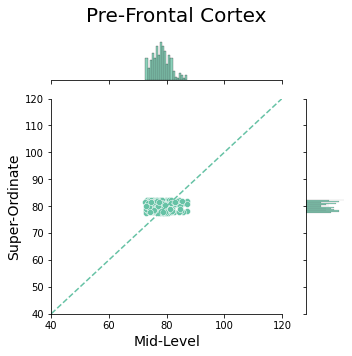

In [727]:
x = onsets[MLP, :]
y = onsets[SOP, :]

ax = sns.jointplot(x=x+np.random.uniform(-2.5, 2.5, x.shape),
                   y=y+np.random.uniform(-2.5, 2.5, x.shape),
                   kind='scatter', 
                   height=5, 
                   xlim=[40, 120], 
                   ylim=[40, 120], 
                   ratio=4, 
                   marginal_kws=dict(bins=20))
ax.ax_joint.plot([0, 300], [0, 300], '--')
ax.ax_joint.set_xlabel('Mid-Level', fontsize=14)
ax.ax_joint.set_ylabel('Super-Ordinate', fontsize=14)

ax.fig.suptitle('Pre-Frontal Cortex', fontsize=20)
ax.fig.tight_layout()

plt.savefig(os.path.join(out_path, "pfc-onset-latency-thresh.jpg"),
            dpi=1200)
# plt.close()